# Preparation

To initialize Julia edit startup.jl on _~/.julia/config/startup.jl_ and add a line with _push!(LOAD_PATH,"/home/folder/to/custom/libraries/")_

In [1]:
using quantum
using rmt
using LinearAlgebra

# Spin chains

In [13]:
"""
Se construye la parte de Ising de una cadena abierta homogenea
"""
function apply_open_chain!(psi,J)
    qubits=trailing_zeros(length(psi))
    for i in 0:(qubits-2) 
        apply_ising!(psi,J,i,i+1)
    end
end
"""
Se construye la parte de Ising inhomogenea
"""
function apply_open_inhomogeneous_chain!(psi,J_hom,J_inhom)
    qubits=trailing_zeros(length(psi))
    apply_open_chain!(psi,J_hom)
    apply_ising!(psi,J_inhom-J_hom,Int(round(qubits/2)-1),Int(round(qubits/2)))
end
"""
Se construye la parte del campo de una cadena de espines
"""
function apply_magnetic_kick!(psi,b)
    qubits=trailing_zeros(length(psi))
    for i in 0:(qubits-1) 
        apply_kick!(psi,b,i)
    end
end;

In [14]:
"""
floquet_open_chain(J,bx,bz,qubits::Int) Operador de Floquet de una cadena abierta y homogenea
"""
function floquet_open_chain(J,b,qubits::Int)
    dim=Int(2^qubits)
    u=zeros(Complex{Float64},dim,dim)
    for i in range(0,dim)
        psi=copy(base_state(i,dim))
        apply_open_chain!(psi,J)
        apply_magnetic_kick!(psi,b)
        u[:,i+1]=psi
    end
    return u
end

"""
floquet_open_inhomogeneous_chain(J_hom,J_inhom,bx,bz,qubits::Int) Operador de Floquet de una cadena abierta 
e inhomogenea
"""
function floquet_open_inhomogeneous_chain(J_hom,J_inhom,b,qubits::Int)
    dim=Int(2^qubits)
    u=zeros(Complex{Float64},dim,dim)
    for i=0:(dim-1)
        #@show i
        psi=copy(base_state(i,dim))
        #@show "hola 1", i
        apply_open_inhomogeneous_chain!(psi,J_hom,J_inhom)
        #@show "hola 2", i

        apply_magnetic_kick!(psi,b)
        u[:,i+1]=psi
    end
    return u 
end

function floquet_chain(J_hom,J_inhom,J_hom_2,J_inhom_2,b,b2,qubits::Int)
    dim=Int(2^qubits)
    u=zeros(Complex{Float64},dim,dim)
    for i in range(0,dim,step=1)
        psi=copy(base_state(i,dim))
        apply_magnetic_kick!(psi,b)
        apply_open_inhomogeneous_chain!(psi,J_hom,J_inhom)
        apply_magnetic_kick!(psi,b2)
        apply_open_inhomogeneous_chain!(psi,J_hom_2,J_inhom_2)
        u[:,i+1]=psi
    end
    return u 
end;

In [15]:
U_KI=floquet_open_inhomogeneous_chain(1.0,4.0,[1.4,0.0,1.4],11);

## Test con propagadores construidos explicitamente

In [16]:
function ising_term(qubits::Int,target_1::Int=1,target_2::Int=target_1+1)
    
    array=Array{Float64,2}[]
    
    for i in range(1,qubits,step=1)
        
        if i==target_1
            push!(array,sigma_z)
            elseif i==target_2
            push!(array,sigma_z)
        else
            push!(array,[[1,0] [0,1]]) 
        end
        
    end
    
    return kron(array...)
    
end

function sigma_term(qubits::Int,target::Int,j::Int)
    array=Array{Complex{Float64},2}[]
    
    for i in range(1,qubits,step=1)
        if i==target
            push!(array,sigmas[j])
        else
            push!(array,[[1,0] [0,1]])
        end
    end
    return kron(array...)
end

sigma_term (generic function with 1 method)

test

In [67]:
state=random_state(4)
init=state
state=exp(-im*ising_term(2,0,1))*init
apply_ising!(init,1,1,2)
norm(init-state)

0.0

### Hamiltonianos

In [69]:
function ham_ising_open_hom(qubits::Int,J)
    
    h=zeros(Int(2^qubits),Int(2^qubits))
    
    for i in range(1,qubits-1,step=1)
        h=ising_term(qubits,i)+h
    end
    
    return J*h
    
end

function ham_ising_open_inhom(qubits::Int,J_hom,J_inhom)
    
    h=zeros(Int(2^qubits),Int(2^qubits))
    for i in range(1,qubits-1,step=1)
        h=ising_term(qubits,i)+h
    end
    h=J_hom*h+ising_term(qubits,Int(round(qubits/2)-1))*(J_inhom-J_hom)
    
    return h
    
end


function ham_field_hom(qubits::Int,b_x,b_z)
    
    h=zeros(Int(2^qubits),Int(2^qubits))
    
    for i in range(1,qubits,step=1)
        h=b_x*sigma_term(qubits,i,1)+b_z*sigma_term(qubits,i,3)+h
    end
    
    return h
    
end

ham_field_hom (generic function with 1 method)

In [70]:
# Se comparan los operadores de floquet de la cadena inhomogenea con acoplamientos Ising aleatorios
J_hom=rand(1)[];
J_inhom=rand(1)[];
H_I=ham_ising_open_inhom(7,J_hom,J_inhom);
H_K=ham_field_hom(7,2.0,1.0);

In [71]:
U_I=exp(-1.0im*H_I);

In [72]:
U_K=exp(-1.0im*H_K);

In [73]:
U_KI=U_K*U_I;

In [74]:
norm(U_KI-floquet_open_inhomogeneous_chain(J_hom,J_inhom,[2.0,0.0,1.0],7))

1.929763173861869e-14

# RMT

# Permutations and development of related stuff

In [13]:
using AbstractAlgebra
using PyPlot

In [27]:
G=SymmetricGroup(2)

Full symmetric group over 2 elements

In [28]:
list=[]
for p in G
    push!(list,matrix_repr(p))
end

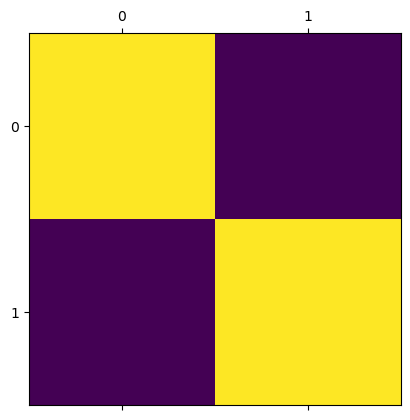

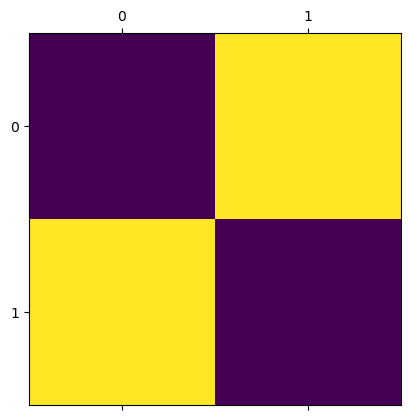

2-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.image.AxesImage object at 0x7f6f2bb0d110>
 PyObject <matplotlib.image.AxesImage object at 0x7f6f2bace150>

In [29]:
map(matshow,list)

# Refreshing copy and other delicate stuff

In [7]:
a=[1,0,1,0]
b=a
a[1]=2
b

4-element Array{Int64,1}:
 2
 0
 1
 0

In [8]:
a=[1,0,1,0]
b=copy(a)
a[1]=2
b

4-element Array{Int64,1}:
 1
 0
 1
 0

In [9]:
a

4-element Array{Int64,1}:
 2
 0
 1
 0

In [19]:
a=[[1,2],[2,1]]
b=copy(a)
a[1]=[4,5]
b

2-element Array{Array{Int64,1},1}:
 [1, 2]
 [2, 1]

In [20]:
a=[[1,2],[2,1]]
b=copy(a)
a[1][2]=3
b

2-element Array{Array{Int64,1},1}:
 [1, 3]
 [2, 1]

In [1]:
a=[[1,2],[2,1]]
b=deepcopy(a)
a[1][2]=3
b

2-element Array{Array{Int64,1},1}:
 [1, 2]
 [2, 1]

In [2]:
a=[[1,2],[2,1]]
b=deepcopy(a)
a[1][2]=3
b

2-element Array{Array{Int64,1},1}:
 [1, 2]
 [2, 1]